<a href="https://colab.research.google.com/github/rahule-1999/DDA-python/blob/main/Week_1/Module_1_2_Image_Analysis_and_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


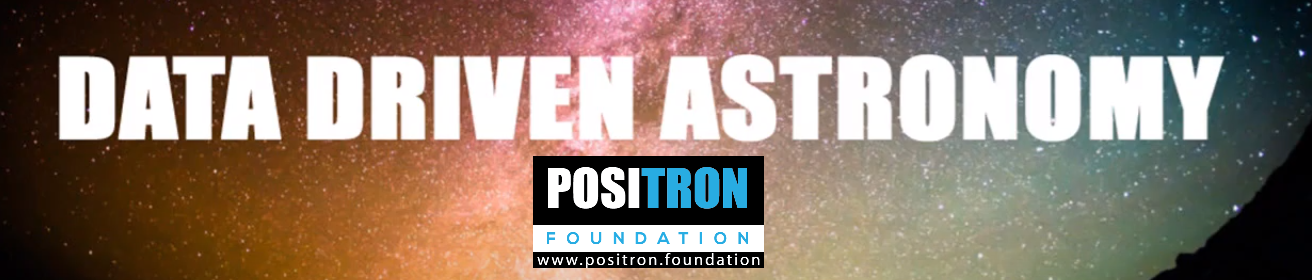




Welcome to **Data Driven Astronomy** Online course organized by **Positron Foundation**


# **Initialization**

In [265]:
!pip install sep --quiet
!pip install photutils --quiet
!pip install astroquery --quiet

In [266]:
import numpy as np
import astropy
import sep
import photutils as phot
from matplotlib import pyplot as plt
from astroquery.skyview import SkyView
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
import astropy.stats as stats
# To improve Aesthetics of plots

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['font.size'] = 15

In [267]:
# Do no change.
!git clone https://github.com/Jack3690/DDA

Cloning into 'DDA'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 413 (delta 97), reused 37 (delta 37), pack-reused 271
Receiving objects: 100% (413/413), 51.18 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [268]:
cd DDA/Week_1/data

/content/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data/DDA/Week_1/data


# **Background estimation and subtraction**

To accurately measure the photometry and morphological properties of astronomical sources, one requires an accurate estimate of the background, which can be from both the sky and the detector. Similarly, having an accurate estimate of the background noise is important for determining the significance of source detections and for estimating photometric errors. 


Using SkyView get 'SDSSg' image of 'NGC 7617' with radius 3 arcminutes and 512 pixels.( Check module 1.1 for help)

In [269]:
position = 'NGC 7617'
radius = 3
# Complete the code 
path = SkyView.get_images(position='NGC 7617',radius=radius*u.arcmin,pixels=512, survey=['SDSSg'])


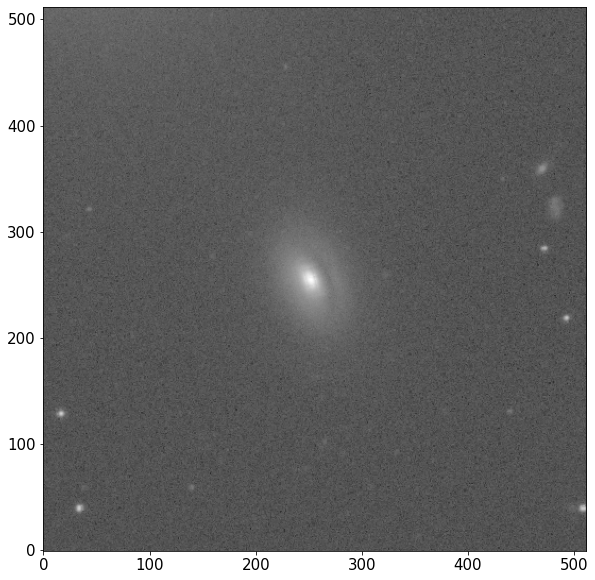

In [270]:
data = path[0][0].data

norm = ImageNormalize(stretch=LogStretch()) # Direct function for Log Stretch

# Henceforth, this should be the standard setting for all image plots
# origin = 'lower'
# cmap = 'gray'
# norm = ImageNormalize(stretch=LogStretch())

plt.imshow(data,origin='lower',cmap='gray',norm=norm)

In [271]:
data = data.byteswap().newbyteorder()  # Run if sep gives an error

## **Estimation**

In [272]:
bkg       = sep.Background(data,bh=64,bw=64,fh=10,fw=10)
bkg_image = bkg.back()
bkg_rms   = bkg.rms()

Here bh and bw are box height and width respectively and represent the height and width in pixels of the box to estimate the background

fh and fw are filter height and width for running convolutions and the box which is part of background estimation

bkg.back() returns the estimated background and bkg.rms() returns the root mean squared value of the estimated background

Write code to display orginal image and bkg_image side by side

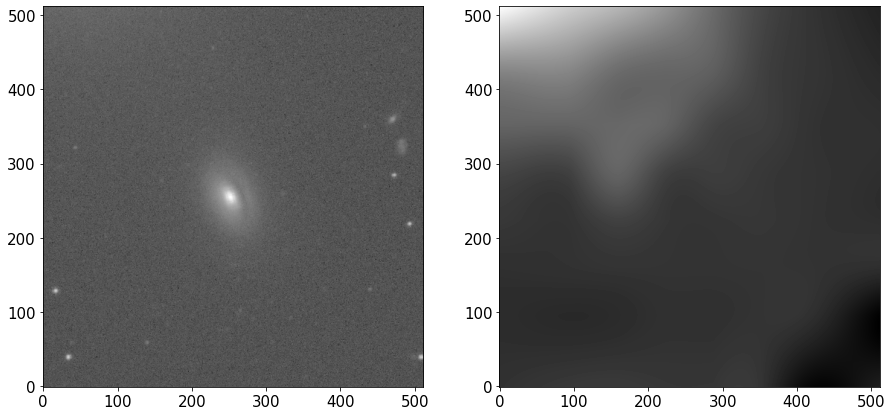

In [273]:
fig=plt.figure(figsize=(15,20))
ax=fig.subplots(1,2)

norm = ImageNormalize(stretch=LogStretch())

ax[0].imshow(data,origin='lower', cmap='gray', norm=norm)
# Complete the code. Do not use norm for bkg_image
ax[1].imshow(bkg_image,origin='lower', cmap='gray')


From the background estimation we see that there's a bright source in the top left corner (when origin='lower')

Using SkyView get 'SDSSg' image of 'NGC 7617' with radius 10 arcminutes and colormap  'hsv'

In [274]:
position = 'NGC 7617'
radius = 10
# Complete the code 
path = SkyView.get_images(position='NGC 7617',radius=radius*u.arcmin,pixels=512, survey=['SDSSg'])


In [275]:
# get data from path
data = path[0][0].data

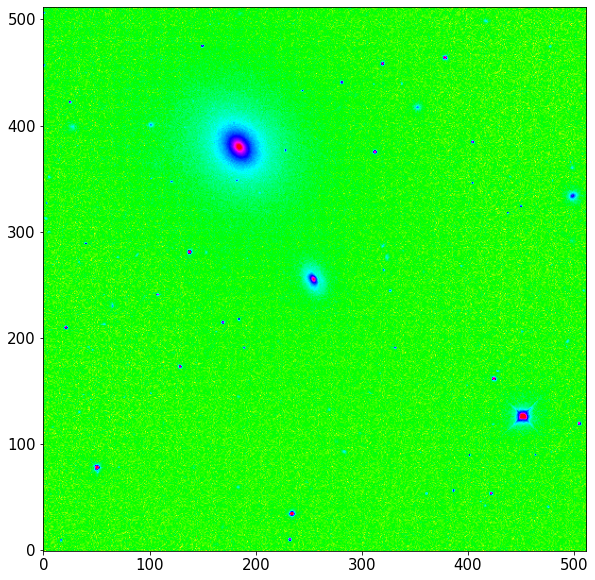

In [276]:
# Plot image with   origin  : lower, cmap : hsv and norm : LogStretch
plt.imshow(data,origin='lower',cmap='hsv',norm=norm)

From the image of NGC 7617 with radius 10 arc minutes we see that there's a very bright source very close to it which is influencing it's background flux.


You are encouraged to play around with the input parameters bh, bw, fh, and fw to learn how they impact the background estimation

## **Subtraction**

This part is fairly straightfoward. For obtaining background subtracted image you simply have to subtract the estimated image from the source image

Subtract bkg_image from data and plot the resultant image with Log stretch

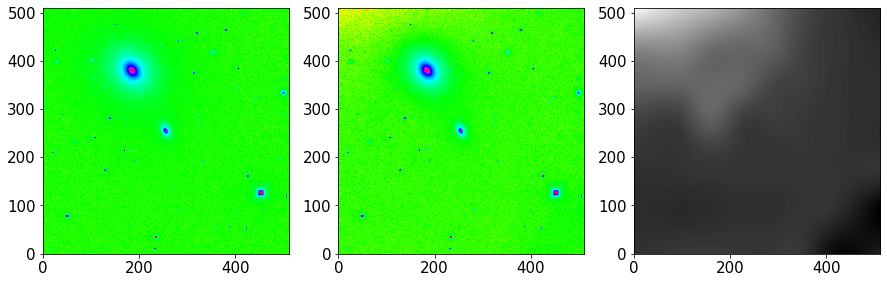

In [277]:
# Complete the code
residual = data - bkg_image
fig=plt.figure(figsize=(15,20))
ax=fig.subplots(1,3)

# Display the residual image with  origin = 'lower', cmap = 'hsv', norm = norm
ax[0].imshow(data,origin='lower',cmap='hsv',norm=norm)
ax[2].imshow(bkg_image,origin='lower',cmap='gray')
ax[1].imshow(residual,origin='lower',cmap='hsv',norm=norm)

# **Source Extraction Using Image Segmentation**

Photutils includes a general-use function to detect sources (both point-like and extended) in an image using a process called image segmentation in the computer vision field. After detecting sources using image segmentation, we can then measure their photometry, centroids, and morphological properties by using additional tools in Photutils.


Use Skyview to obtain 'SDSSi' image of 'Abell 400' with radius 10 arcminutes and 512 pixels

In [175]:
position = 'Abell 400'
radius   = 10
# Complete the code 
path = SkyView.get_images(position=position,radius=radius*u.arcmin,pixels=512, survey=['SDSSi'])


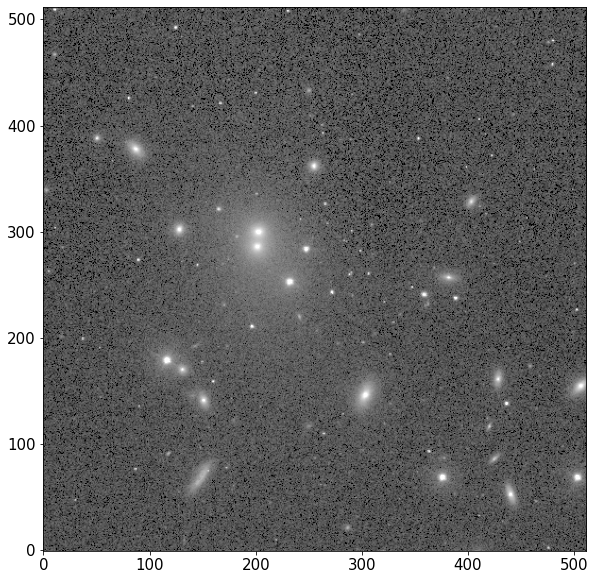

In [176]:
data = path[0][0].data                            # Image data

# Plot data with standard setting
plt.imshow(data,origin='lower',cmap='gray',norm=norm)

In the image above we see a number of galaxies. Our objective is to find coordinates of all bright sources. This is a standard problem in Astronomy and is called as Source extraction. There are number of methods for source detection, we will be using the method of Segmentation.

To able to associate coordinates with the sources in the image, first we need to know the coordinates (RA and Dec) associated to each point in the image. This is where where we use the [WCS](http://tdc-www.harvard.edu/wcstools/wcstools.wcs.html) feature of a FITS image. 



In [177]:
wcs = WCS(path[0][0].header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 44.4058  6.0125  
CRPIX : 256.5  256.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0003255208333333333  0.0003255208333333333  
NAXIS : 512  512

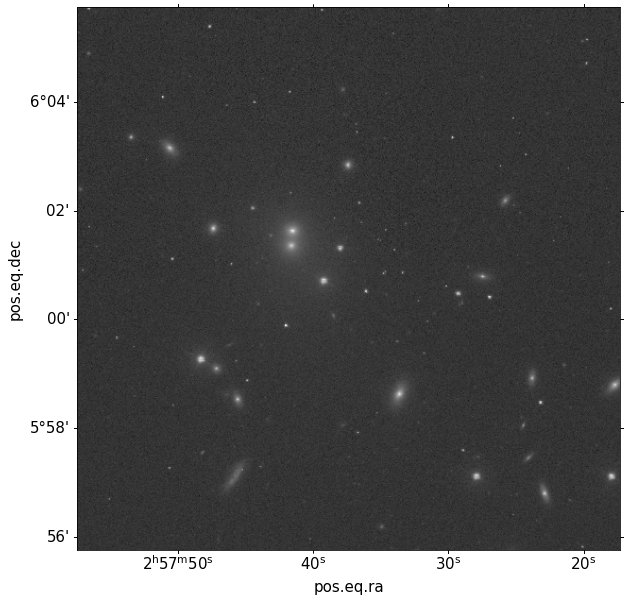

In [178]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = wcs) # Adding WCS axes to the plot
norm = ImageNormalize(data,stretch=LogStretch())
ax.imshow(data, cmap = 'gray',norm=norm)

## **3 Sigma**



In the empirical sciences the so-called three-sigma rule of thumb expresses a conventional heuristic that nearly all values are taken to lie within three standard deviations of the mean, and thus it is empirically useful to treat 99.7% probability as near certainty

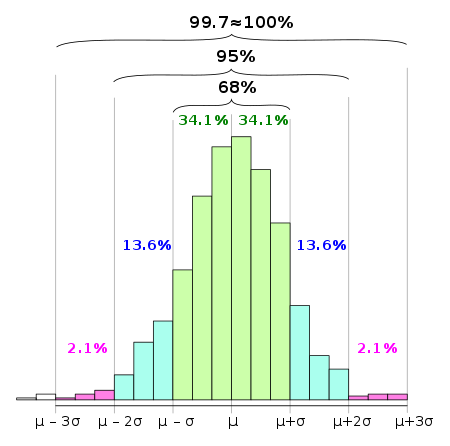

In our context we'll be assigning coordinates to all sources which have flux greater than 3 sigma

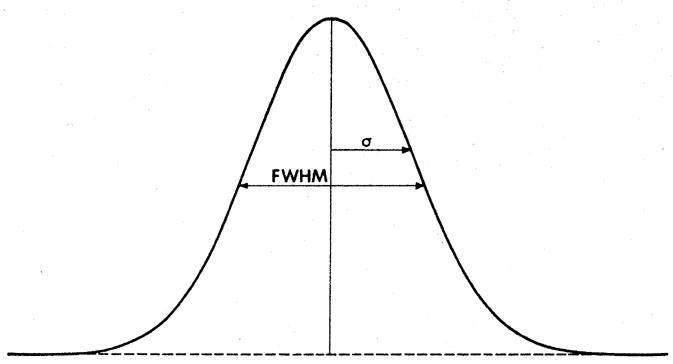

We will look for sources which lie between 3 FWHM

Now

FWHM = $2\sqrt{2\ln2}\sigma$

This implies

sigma $\approx$ 1/2.354 FWHM

stats.gaussian_fwhm_to_sigma gives the value of 1/$2\sqrt{2\ln2}$ to a higher precision


## **Detection**

In [179]:
sigma = 3.0 * stats.gaussian_fwhm_to_sigma  # FWHM = 3.
sigma

1.2739827004320285

Next we create a filter for convolution. You can learn more about convolution [here](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

In [180]:
kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

Plot 2D data 'kernel' to visualize the filter

**Exercise 2.1**

Write code to estimate background of Abell 400 with bh=bw=8 and fh=fw=3.

In [181]:
data = data.byteswap().newbyteorder()

In [182]:
# Complete the code
bkg       = sep.Background(data,bh=8,bw=8,fh=3,fw=3)


# Let's use a threshold of 5*RMS above the background.

threshold = bkg.back() + (5 * bkg.rms()) # 

Display 2D data in the variable threshold to visualize the background

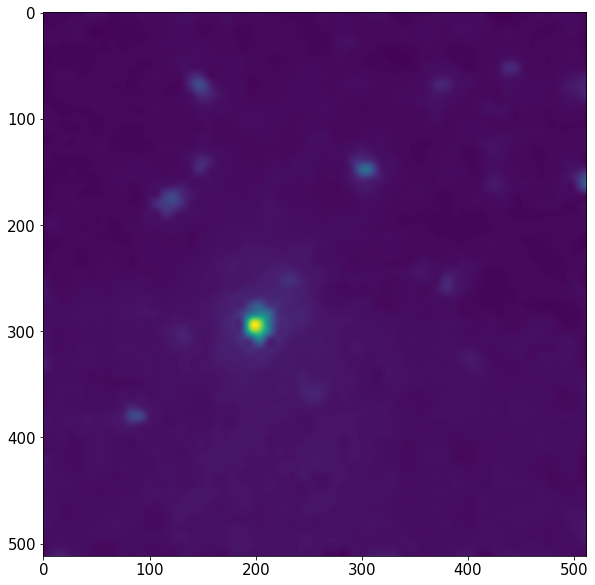

In [183]:
plt.imshow(threshold)

In [184]:
segm = phot.detect_sources(data, threshold, npixels = 5, kernel=kernel)
cmap_segm = segm.make_cmap(seed=123)

Write code for making following subplots 

---
Subplot left

Data : segm 

cmap : cmap_segm

interpolation : 'nearest'

origin : 'lower'

---

Subplot right 

Data : data

cmap : 'Greys'

norm : LogStretch()

origin : 'lower'

---

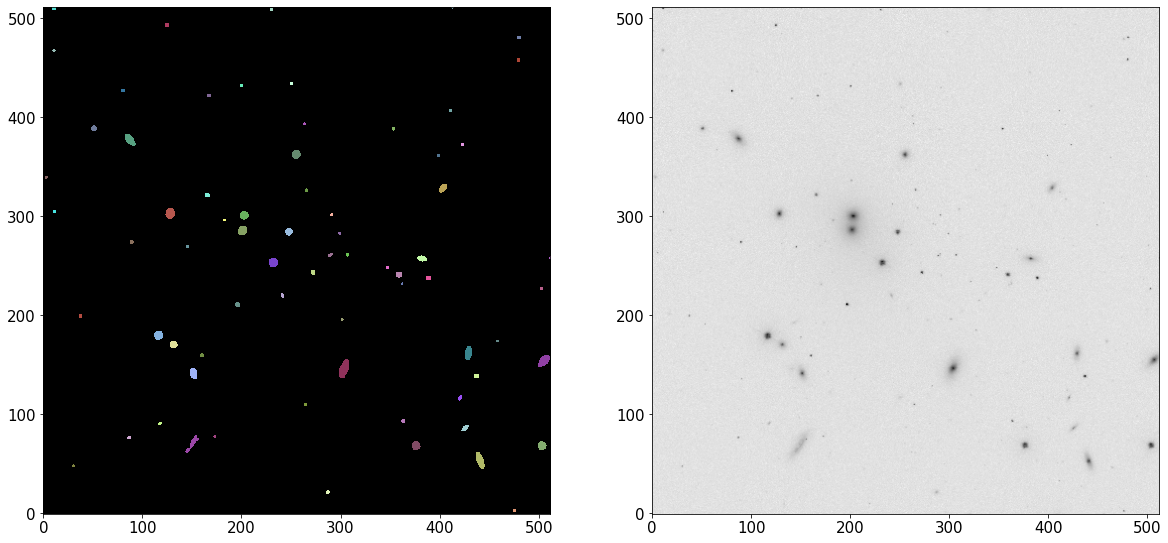

In [185]:
fig, ax = plt.subplots(1,2, figsize = (20,10))


norm = ImageNormalize(stretch=LogStretch())

ax[0].imshow(segm, origin='lower', cmap=cmap_segm, interpolation = 'nearest')

ax[1].imshow(data, origin='lower', cmap='Greys',norm=norm)



In [186]:
sources = phot.SourceCatalog(data, segm,wcs = wcs)
catalog = sources.to_table()

# optional format
catalog['xcentroid'].info.format = '.2f'  
catalog['ycentroid'].info.format = '.2f'
catalog['kron_flux'].info.format = '.2f'

Thus we have a catalog of all sources in the image

In [187]:
catalog

<QTable length=71>
label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
int64  float64   float64  ...     float64      float64    float64   
----- --------- --------- ... --------------- --------- ------------
    1    475.19      2.68 ...             nan      4.25          nan
    2    286.34     21.47 ...             nan     10.36          nan
    3    439.72     52.91 ...             nan    161.75          nan
    4     29.94     47.64 ...             nan      2.43          nan
    5    149.49     70.10 ...             nan    164.62          nan
    6    375.55     69.01 ...             nan    205.94          nan
    7    502.65     68.92 ...             nan    217.07          nan
    8     86.64     76.75 ...             nan      4.76          nan
    9    172.18     77.97 ...             nan      2.51          nan
  ...       ...       ... ...             ...       ...          ...
   62     80.12    425.96 ...             nan     25.88          nan
   63    199.84    430.85 ...             nan      6.88          nan
   64    249.92    432.99 ...             nan     10.18          nan
   65    479.01    457.76 ...             nan     10.96          nan
   66     10.51    467.01 ...             nan      6.66          nan
   67    479.53    480.01 ...             nan      9.46          nan
   68    124.37    492.24 ...             nan     19.85          nan
   69    230.07    507.88 ...             nan      8.76          nan
   70     10.70    509.11 ...             nan     17.62          nan
   71    412.07    509.94 ...             nan      1.77          nan

Let's plot [Kron Apertures](https://wise2.ipac.caltech.edu/staff/jarrett/2mass/3chan/kron/kron.html) around sources

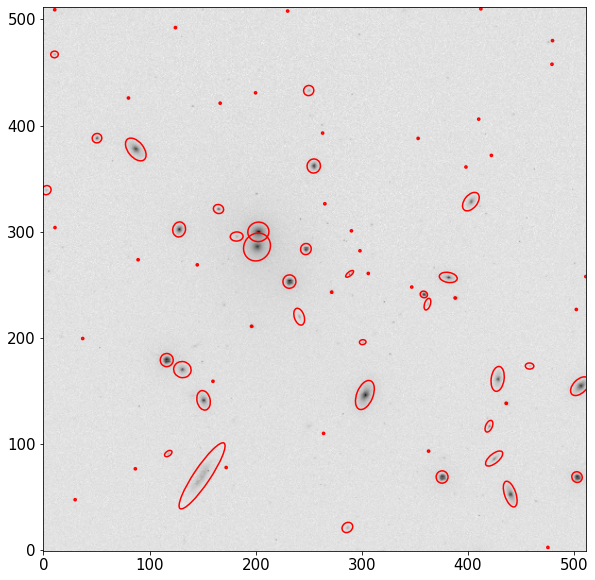

In [188]:
fig,ax = plt.subplots(1)
ax.imshow(data, origin = 'lower', cmap = 'Greys' , norm=norm)
for aperture in sources.kron_aperture:
  if aperture is not None:
    aperture.plot(axes=ax, color='red', lw=1.5)

## **Querying Catalog**

Now that we have tabular data, we can pass queries for understanding the distribuition.

In [189]:
label = catalog[catalog['semimajor_sigma']==catalog['semimajor_sigma'].max()]['label'] # Searching for label with longest semimajor axis ( based of segmentation map)

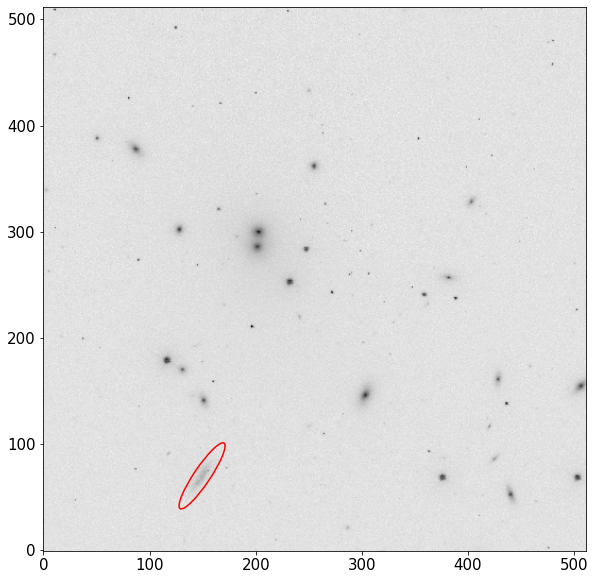

In [190]:
# Getting the source using label
q = sources.get_label(label)

# Plotting the queried source and marking it using aperture
fig,ax = plt.subplots(1)
ax.imshow(data, cmap = 'Greys' , norm=norm,origin='lower')
for aperture in q.kron_aperture:
  if aperture is not None:
    aperture.plot(axes=ax, color='red', lw=1.5)

In [191]:
q.to_table() # Converting to QTable

<QTable length=1>
label     xcentroid          ycentroid     ...     kron_flux      kron_fluxerr
                                           ...                                
int64      float64            float64      ...      float64         float64   
----- ------------------ ----------------- ... ------------------ ------------
    5 149.49055914429857 70.10369783042995 ... 164.62050317764158          nan

In [192]:
q.to_table()['sky_centroid'] # Position of the source that can be passed on to Skyview 

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(44.44049531, 5.95214858)]>

# **Data Modelling**

Preliminary analysis in astronomical image processing
includes understanding the dimensional properties or the shape
index profile of the celestial object in the image. For quantifying the dimensions astronomers often choose a profile and fit it to the data. 

Astropy has provision for multidimensional curve fitting and has quite many profiles for modeling the data. [Learn more](https://docs.astropy.org/en/stable/modeling/predef_models2D.html)


In [193]:
from astropy.modeling import models, fitting

Use Skyview to obtain 'SDSSz' image of M 89' with radius 3 arcminutes and 512 pixels

In [194]:
# Complete the code
position = 
radius   =  
# Complete the code 
path     = 

SyntaxError: ignored

In [ ]:
data =                        # Image data

# Plot the data with standard settings


In [ ]:
# Initialize Guassian2D model
init = model.Gaussian2D()

In [ ]:
# Choosing the fitting method
fit = fitting.LevMarLSQFitter()

# Creating a x,y mesh for giving every point in the image an x,y coordinate and normalizing it to [-1,1]
y,x = np.mgrid[-256:256,-256:256]/256

In [ ]:
# Fit the model to data
model = fit(init,x,y,z = data)
model

In [ ]:
model(x,y) # Model array

In [ ]:
# Plotting the model

norm = 



**Exercise 2.2**

Write code to model 'M 89' image data using Sersic2D profile

In [ ]:
# Initializing the model
init = 

In [ ]:
# Choosing the fitting method
fit = 

# Creating a x,y mesh for giving every point in the image an x,y coordinate and normalizing it to [-1,1]

y,x = 

In [ ]:
# Fit the model to data

model = 


In [ ]:
# Plot the model



# **Residual Image**

When we subtract the model from data we get residual image which often reveals underlying structures

**Exercise 2.3**

Complete the code to produce residual image

In [ ]:
# Use Skyview to get 'SDSSi' image of 'manga 8082-6102' with radius 1 arc minute and 512 pixels

position = 
radius   = 
path     = 


In [ ]:
# Store the image data and plot it using standard setting
data = 



In [ ]:
# Initialize with Sersic2D model
init = 

# Choosing the fitting method
fit = 

# Creating a x,y mesh for giving every point in the image an x,y coordinate and normalizing it to [-1,1]
 
y,x = 
# Fit the model to data
model = 

# Plot the model using standard setting


In [ ]:
# Subtract model from data and plot it
residual =

# Plot the residual with standard setting except cmap = 'hsv'


# **Puzzle II**

Use Skyview to obtain 'SDSSi' band image of 'Abell 1656' with radius 15 arcminutes and 1024 pixels

In [ ]:
# Complete the code
position = 
radius   =
path     = 

In [ ]:
data = 

# Plot data with standard setting but with cmap = 'gray'



In [ ]:
# Use FWHM = 3 and convert to sigma
sigma =                           # FWHM = 3.

# Make gaussian kernal with filter size 3x3 and normalize it.

kernel = 

# Estimate backgound with bh=bw=16 and fh=fw=3. Use data.byteswap().newbyteorder() if required

data = data.byteswap().newbyteorder()

bkg = 

# Using background and background rms set threshold to background plus 5 times the rms

threshold =

# Estimate the segmentation map with npixels = 30 and gaussian kernel

segm = 

# Create cmap for segmentation

cmap_segm = 

# Plot segmentation map and the original data. Similar to prior example on segmentation

fig = plt.figure(figsize=(15,9))
ax = fig.subplots(1,2)





In [ ]:
# Create WCS object using the header file
wcs = 

# Create catalog using data, segmentation map and wcs object

sources = 

# Convert catalog to table

catalog = 

# Format 'xcentroid', 'ycentroid' and 'kron_flux' to '.2f'



In [ ]:
catalog

In [ ]:
# Plot the Apertures



In [ ]:
# Filter catalog to ycentroid < 700
catalog = 

In [ ]:
# Query the catalog for source which has largest 'area'

label = 

# Get the data for the label

q = 

# Plot the data and show the queried source and show the source



In [ ]:
# Convert query object to QTable
Q = q.to_table()
Q 

In [ ]:
# Retrieve position of source and use it to acquire 'SDSSi' image with radius 15 arcminute and 512 pixels

position =  Q['sky_centroid']
radius   =  
path     =  

data_s =     # Image data 

# Plot data with the standard settings but with cmap = 'gray'



Load the image data stored in the fits file 'puzzle_2.fits' and display it using LogStretch, 'gray' cmap and origin='lower'

In [ ]:
f = 

dat =       # Puzzle data

# Plot the data


Subtract data_s from dat and plot it with origin='lower' and cmap = 'gray'

In [ ]:
diff = 


Save the output diff as a fits file with name 'puzzle_2_solution.fits' and download it for submission and for future reference.

In [ ]:
hdu  = fits.PrimaryHDU(diff)
# Complete the code
hdul =
